In [46]:
# let's try with a Siamese network

In [1]:
import tensorflow as tf

2023-06-17 16:53:12.977871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 16:53:13.944218: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# filter outliers and sample data
time_IQR = find_outlier_threshold(seq_mapped.specs.apply(lambda x : x.shape[1]), k=1.5)
sample_data =  seq_mapped.loc[  seq_mapped.specs.apply(lambda x : x.shape[1] >= time_IQR[0] and x.shape[1] <= time_IQR[1] ) ] \
    .sample(frac=.1)

MAX_LENGTH = time_IQR[1] # set max length to upper 1.5 * Q3 quartile

MAX_LENGTH

NameError: name 'find_outlier_threshold' is not defined

In [80]:
syls = [s for s, v in sample_data.syllableID_et_ward.value_counts().to_dict().items() if v>=10]

In [19]:
# to generate anchor and positive spectrograms:
# sample items from the same et_ward ID. I use it as a proxy

In [81]:
%%time 

anchor_specs = []
positive_specs = []

for s in syls:

    # I picked up 10 samples for each syllables
    for _ in range(11):
        a, p = sample_data.query(f'syllableID_et_ward in [{s}]').specs.sample(2).values
        anchor_specs.append(a)
        positive_specs.append(p)

CPU times: user 919 ms, sys: 0 ns, total: 919 ms
Wall time: 918 ms


In [82]:
a, p = sample_data.query(f'syllableID_et_ward in [{s}]').specs.sample(2).values

In [83]:
%%time

from joblib import Parallel, delayed
from tqdm import tqdm

anchor_data = Parallel(n_jobs=-1, verbose=2)(delayed(

    spec_to_image

)(spec, resolution = 200, mode = 'constant', max_length = 256, resize = True) for batch in tqdm(group_list(anchor_specs, 50)) for spec in batch);

positive_data = Parallel(n_jobs=-1, verbose=2)(delayed(

    spec_to_image

)(spec, resolution = 200, mode = 'constant', max_length = 256, resize = True) for batch in tqdm(group_list(positive_specs, 50)) for spec in batch);



0it [00:00, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.

1it [00:05,  5.22s/it]
2it [00:09,  4.57s/it]
3it [00:09,  2.63s/it][Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    9.9s

4it [00:10,  1.76s/it]
5it [00:10,  1.21s/it]
6it [00:10,  1.07it/s]
7it [00:10,  1.47it/s][Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   11.2s

8it [00:11,  1.66it/s]
9it [00:11,  1.86it/s]
10it [00:11,  2.31it/s]
11it [00:12,  2.48it/s]
12it [00:12,  1.04s/it]
[Parallel(n_jobs=-1)]: Done 583 out of 583 | elapsed:   12.7s finished

0it [00:00, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.

3it [00:00, 11.52it/s]
5it [00:00, 10.90it/s][Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.7s

7it [00:00,  7.12it/s]
8it [00:01,  6.54it/s]
9it [00:01,  6.15it/s]
11it [00:01,  6.68it/s]
12it [00:01,  6.97it/s]
[Parallel(n_jobs=-1)]: Done 520 out of 583 | elapsed:    1.9s remaining:    0.2s


CPU times: user 5.7 s, sys: 5.78 s, total: 11.5 s
Wall time: 14.8 s


[Parallel(n_jobs=-1)]: Done 583 out of 583 | elapsed:    2.1s finished


In [84]:
# fake three layers RGB

anchor_data = [ np.stack((x,)*3, axis=-1) for x in anchor_data]
positive_data = [ np.stack((x,)*3, axis=-1) for x in positive_data]


In [85]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_data)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_data)

In [86]:
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_data)
rng.shuffle(positive_data)

negative_data = anchor_data + positive_data
np.random.RandomState(seed=32).shuffle(negative_data)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_data)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [87]:
_total_specs = len(anchor_data)

def get_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        anchor, positive, negative
    )

# create dataset
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(get_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(_total_specs * 0.8))
val_dataset = dataset.skip(round(_total_specs * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

2023-06-17 12:24:03.707167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype float and shape [1166,200,200,3]
	 [[{{node Placeholder/_4}}]]
2023-06-17 12:24:03.707689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype float and shape [1166,200,200,3]
	 [[{{node Placeholder/_4}}]]


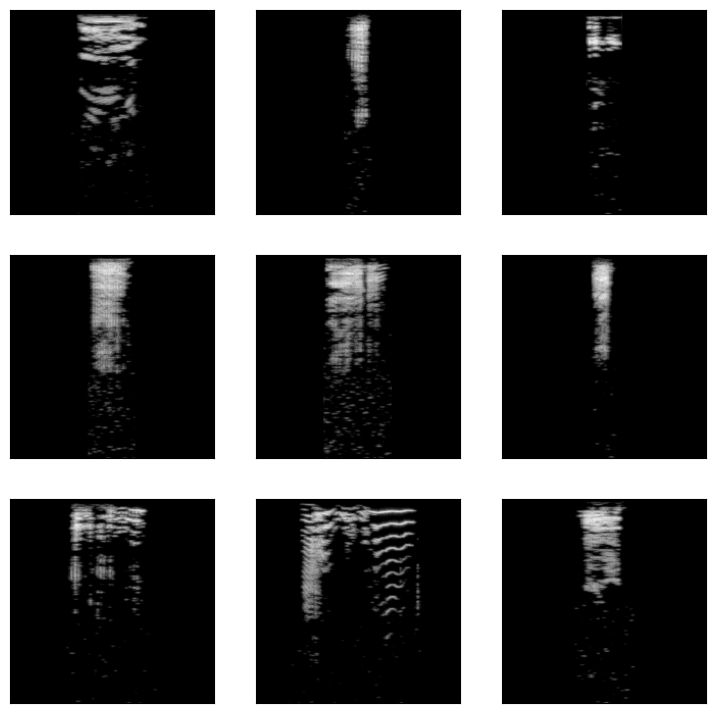

In [90]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

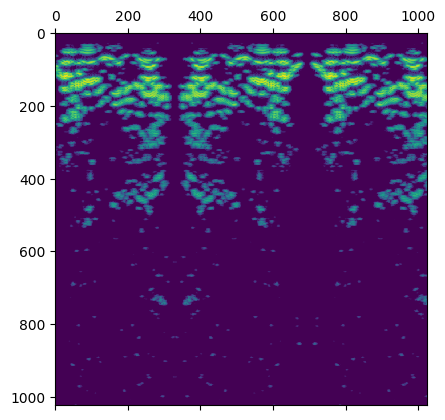

In [124]:
x = seq_mapped.query(f'syllableID_et_ward in {syls}').sample().specs.values[0]

plt.matshow( spec_to_image(x, 1024, mode = 'symmetric') )

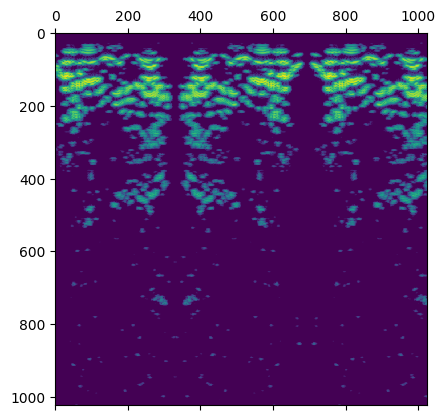

In [125]:
plt.matshow( spec_to_image(x, 1024, mode = 'reflect') )

In [161]:
# Siamese Twins

In [42]:
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


In [3]:
import tensorflow.keras.backend as K
K.clear_session()

In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, False)

In [43]:
target_shape = (200, 200)

base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [49]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [91]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [97]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=30, validation_data=val_dataset)

Epoch 1/30
15/15 [==============================] - 18s 385ms/step - loss: 0.2678 - val_loss: 0.2088
Epoch 2/30
15/15 [==============================] - 3s 199ms/step - loss: 0.2208 - val_loss: 0.1724
Epoch 3/30
15/15 [==============================] - 3s 175ms/step - loss: 0.2456 - val_loss: 0.2490
Epoch 4/30
15/15 [==============================] - 3s 176ms/step - loss: 0.2478 - val_loss: 0.2300
Epoch 5/30
15/15 [==============================] - 3s 173ms/step - loss: 0.2351 - val_loss: 0.2263
Epoch 6/30
15/15 [==============================] - 3s 173ms/step - loss: 0.2267 - val_loss: 0.1767
Epoch 7/30
15/15 [==============================] - 3s 178ms/step - loss: 0.2209 - val_loss: 0.2383
Epoch 8/30
15/15 [==============================] - 3s 205ms/step - loss: 0.1935 - val_loss: 0.2307
Epoch 9/30
15/15 [==============================] - 3s 177ms/step - loss: 0.2085 - val_loss: 0.1941
Epoch 10/30
15/15 [==============================] - 3s 178ms/step - loss: 0.1874 - val_loss: 0.153

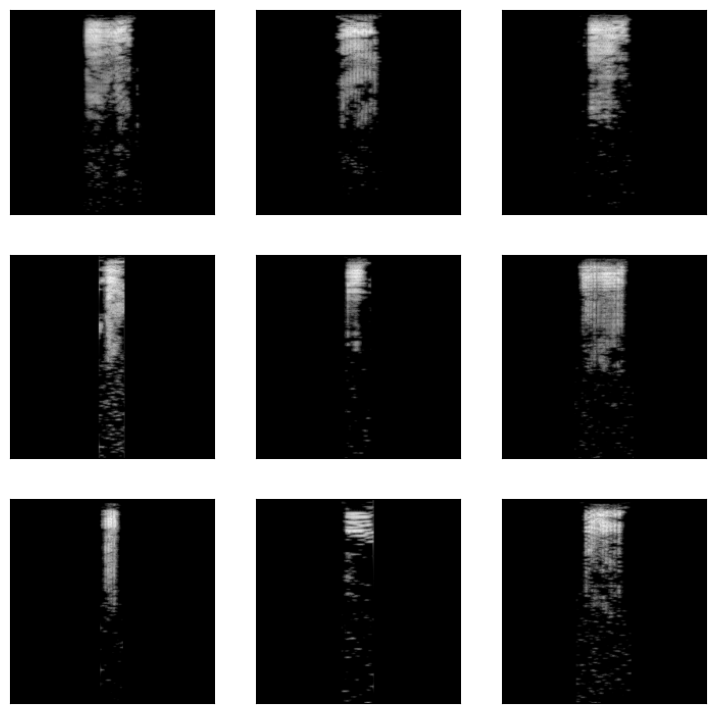

In [107]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [108]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


Positive similarity: 0.9999938
Negative similarity 0.9999878


In [ ]:
.get_tensor_by_name("import/layer_name")

In [104]:
base_cnn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           